In [1]:
import spacy
import spacy.cli
from spacy import displacy
from nltk.stem import WordNetLemmatizer
from graph.graph import Graph, visualize_graph
from graph.edge import Edge
from graph.vertex import Vertex

In [15]:
spacy.cli.download("en_core_web_lg")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 1.5 MB/s eta 0:00:0000:0100:09
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [17]:
nlp = spacy.load("en_core_web_lg")
lemmatizer = WordNetLemmatizer()

## Обработка глагольных рёбер

In [21]:
def get_syntactic_relations(doc):
    """
    Извлекает синтаксические связи (именные группы, включая прилагательные и артикли) из текста.
    Возвращает список троек (субъект, глагол, объект), где субъект и объект — это именные группы.
    Также обрабатывается сочетание глагола с предлогом как единое ребро.
    """
    chunks = []  # Список для хранения именных групп
    relations = []  # Список для хранения связей (субъект, глагол, объект)
    subjects = {}  # Словарь для хранения подлежащих

    # Добавляем именные группы (NOUN CHUNKS) и нормализуем их
    for chunk in doc.noun_chunks:
        normalized_chunk = ' '.join([lemmatizer.lemmatize(token.text.lower(), pos='n') for token in chunk])
        chunks.append((chunk.start_char, chunk.end_char, chunk, normalized_chunk, chunk.root.head, chunk.root.dep_))

    # Добавляем подлежащие
    for chunk in chunks:
        if chunk[5] == 'nsubj':
            subjects[chunk[4]] = chunk[3]  # Связываем сказуемое и подлежащее

    # Добавляем связи для глаголов и предлогов
    for i, chunk in enumerate(chunks):
        # Связи с глаголами
        if chunk[4].pos_ == 'VERB' and chunk[5] != 'nsubj':
            subject = subjects.get(chunk[4], None)
            if subject:
                relations.append((subject, chunk[4].text, chunk[3]))  # (субъект, глагол, объект)

        # Обрабатываем сочетания глаголов и предлогов как единое ребро
        if chunk[4].pos_ == 'VERB' and i + 1 < len(chunks):
            next_chunk = chunks[i + 1]
            if next_chunk[4].pos_ == 'ADP':  # Если следующий элемент - предлог
                subject = subjects.get(chunk[4], None)
                if subject:
                    # Создаем связь как единое ребро (глагол + предлог)
                    relation_text = f"{chunk[4].text} {next_chunk[4].text}"
                    relations.append((subject, relation_text, next_chunk[3]))  # (субъект, глагол + предлог, объект)

    return relations

In [22]:
text = """How are living organisms different from inanimate matter? There are obvious answers in terms
of the chemical composition and structure, but when it comes to the central processes in the evolution
of life, the distinction is far less obvious. In the tradition of Darwin-Wallace, it is tempting to
posit that life is defined by evolution through the survival of the fittest. However, the
uniqueness of this process to life could be questioned because the entire history of the universe
consists of changes where the most stable (the fittest) structures survive. The process of
replication itself is not truly unique to biology either: crystals do replicate. On the macroscopic
scales of space and time, however, life clearly is a distinct phenomenon. To objectively define
the features that distinguish life from other phenomena that occur in the universe, it seems
important to examine the key processes of biological evolution within the framework of
theoretical physics."""
    
doc = nlp(text)
pairs = get_syntactic_relations(doc)

graph1 = Graph()

# Добавляем вершины и рёбра
for pair in pairs:
    try:
        graph1.add_vertex(pair[0])
    except:
        pass
    try:
        graph1.add_vertex(pair[2])
    except:
        pass
    graph1.add_edge(pair[0], pair[2], pair[1], 0, 0)

# Выводим граф
print("Graph structure:")
print(graph1)
print("\nDetailed representation:")
print(repr(graph1))

print("\nEdges:")
for concept in graph1.vertices.keys():
    print(f"Concept: {concept}")
    print(graph1.get_vertex_edges(concept))

print("\nVertices:")
for concept in graph1.vertices.keys():
    print(graph1.vertices[concept])

Graph structure:
Graph(vertices=9, edges=6)

Detailed representation:
Graph(
	vertices=[Vertex(concept='it', words=['it']), Vertex(concept='the central process', words=['the central process']), Vertex(concept='the entire history', words=['the entire history']), Vertex(concept='the universe', words=['the universe']), Vertex(concept='crystal', words=['crystal']), Vertex(concept='the macroscopic 
 scale', words=['the macroscopic \n scale']), Vertex(concept='that', words=['that']), Vertex(concept='life', words=['life']), Vertex(concept='other phenomenon', words=['other phenomenon'])],
	edges=[Edge(it <--[comes to]--> the central process), Edge(the entire history <--[consists of]--> the universe), Edge(crystal <--[replicate On]--> the macroscopic 
 scale), Edge(that <--[distinguish]--> life), Edge(that <--[distinguish from]--> other phenomenon), Edge(that <--[occur in]--> the universe)]
)

Edges:
Concept: it
[Edge(it <--[comes to]--> the central process)]
Concept: the central process
[Edge(

## Обработка предложных рёбер

In [33]:
def find_nearest_vertex(token, chunk_to_vertex):
    """
    Ищет ближайшую вершину для токена, поднимаясь вверх по дереву зависимостей.
    """
    visited = set()
    while token and token not in chunk_to_vertex:
        if token in visited or token.head == token:
            return None  # Защита от бесконечного цикла
        visited.add(token)
        token = token.head  # Поднимаемся выше в дереве
    return chunk_to_vertex.get(token)

In [32]:
def process_token(token, graph, chunk_to_vertex):
    """
    Обрабатывает токен, добавляя рёбра между существующими вершинами (именными группами).
    """
    for child in token.children:
        head_vertex = find_nearest_vertex(token, chunk_to_vertex)
        child_vertex = find_nearest_vertex(child, chunk_to_vertex)
        
        print(f"Checking edge: {token.text} -> {child.text}")
        print(f"Head vertex: {head_vertex}, Child vertex: {child_vertex}")
        
        if head_vertex and child_vertex and token.pos_ == "ADP":  # Обрабатываем только предлоги
            edge_tuple = (head_vertex.concept, child_vertex.concept, token.text)
            
            # Проверяем, есть ли уже такое ребро
            if edge_tuple not in {(e.agent_1, e.agent_2, e.meaning) for e in graph.edges}:
                print(f"Adding edge: {head_vertex.concept} --[{token.text}]--> {child_vertex.concept}")
                graph.add_edge(head_vertex.concept, child_vertex.concept, token.text, 1, 0)
        
        process_token(child, graph, chunk_to_vertex)

In [34]:
chunk_to_vertex = {}

# Добавляем вершины только для именных групп (исключаем глаголы и наречия)
for chunk in doc.noun_chunks:
    vertex = Vertex(chunk.text, [chunk.text])
    
    # Проверяем, существует ли вершина с таким концептом
    if vertex.concept not in graph1.vertices:
        graph1.add_vertex(vertex.concept, vertex.words_of_concept)
    
    # Привязываем root токен к вершине
    chunk_to_vertex[chunk.root] = vertex

# Добавляем рёбра между существующими вершинами
for token in doc:
    if token.pos_ == "ADP":  # Обрабатываем только предлоги
        print(f"Processing token: {token.text} ({token.pos_})")
        process_token(token, graph1, chunk_to_vertex)

Processing token: from (ADP)
Checking edge: from -> matter
Head vertex: Vertex(concept='living organisms', words=['living organisms']), Child vertex: Vertex(concept='inanimate matter', words=['inanimate matter'])
Adding edge: living organisms --[from]--> inanimate matter
Checking edge: matter -> inanimate
Head vertex: Vertex(concept='inanimate matter', words=['inanimate matter']), Child vertex: Vertex(concept='inanimate matter', words=['inanimate matter'])
Processing token: in (ADP)
Checking edge: in -> terms
Head vertex: Vertex(concept='obvious answers', words=['obvious answers']), Child vertex: Vertex(concept='terms', words=['terms'])
Adding edge: obvious answers --[in]--> terms
Checking edge: terms -> 

Head vertex: Vertex(concept='terms', words=['terms']), Child vertex: Vertex(concept='terms', words=['terms'])
Checking edge: terms -> of
Head vertex: Vertex(concept='terms', words=['terms']), Child vertex: Vertex(concept='terms', words=['terms'])
Checking edge: of -> composition
Head

## Визуализация

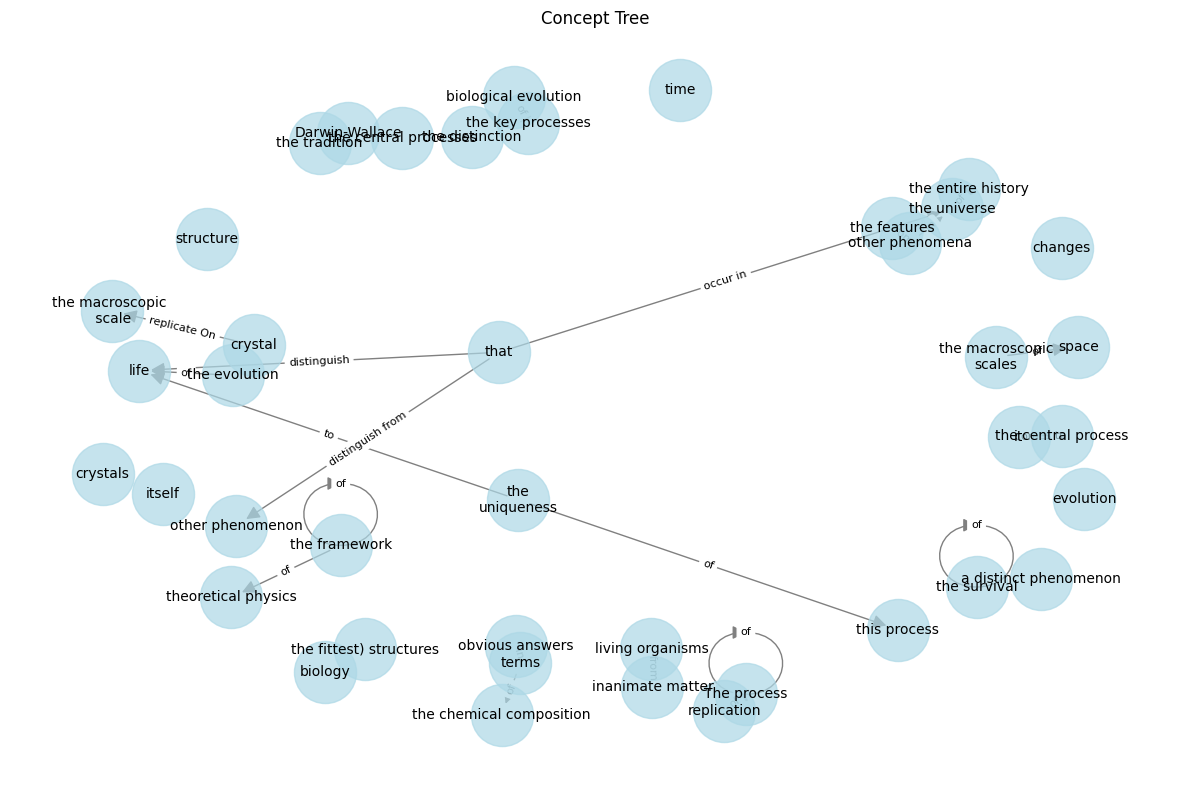

In [47]:
visualize_graph(graph1)

In [46]:
displacy.render(doc, style='dep')